In [1]:
import numpy as np
import keras
from sklearn.model_selection import KFold
import datasets

Using TensorFlow backend.


In [2]:
X_train, y_train, X_test = datasets.load_data()
y_train_cat = keras.utils.to_categorical(y_train)
kf = KFold(n_splits=4, shuffle=True, random_state=212)

Load the data from layer 1 classifiers

In [3]:
X_meta_train, X_meta_test = datasets.load_models()

In [31]:
from keras.layers import *
from keras.layers.core import *
from keras.models import Sequential, Model

In [42]:
def build_model():
    meta = Sequential()
    meta.add(Dense(20, activation='relu', input_shape=(45,))) 
    meta.add(Dropout(0.5))
#     meta.add(Dense(20, activation='relu'))
#     meta.add(Dropout(0.4))
    
    orig_data = Sequential()
    orig_data.add(Dropout(0.5, input_shape=(1000,)))
    orig_data.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    orig_data.add(Dropout(0.5))
    
    merged = Merge([meta, orig_data], mode='concat')
    
    final_model = Sequential()
    final_model.add(merged)
    final_model.add(Dense(2, activation='softmax'))

    final_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return final_model

In [56]:
from keras.callbacks import EarlyStopping
from sklearn.ensemble import BaggingClassifier
from keras.wrappers.scikit_learn import KerasClassifier
cb = EarlyStopping(patience=7)
def BaggedNN(n_bags=10):
    classes_train = np.empty(y_train.shape)
    classes_test = np.empty(X_test.shape[0])
    cursplit = 0;
    
    for train_index, test_index in kf.split(X_train, y_train):
        cursplit += 1
        print('Bagged NN, split=%d' % (cursplit))
        models = []
        for bag in range(n_bags):
            print('Bag %d' % bag)
            actual_indices = np.random.choice(train_index, train_index.shape[0])
            model = KerasClassifier(build_fn=build_model, epochs=50, batch_size=32, verbose=0)
            model.fit([X_meta_train[actual_indices], X_train[actual_indices]], y_train[actual_indices])
            models.append(model)
        raw_test_results = np.array([model.predict([X_meta_train[test_index], X_train[test_index]]) for model in models])
        classes_train[test_index] = np.mean(raw_test_results, axis=0)
        print('Eval accuracy: %f' % (1 - np.sum(np.abs(np.rint(classes_train[test_index]) - y_train[test_index])) / y_train.shape[0]))
    
    print('NN, test')
    models = []
    for bag in range(n_bags):
        print('Bag %d' % bag)
        actual_indices = np.random.choice(range(X_train.shape[0]), X_train.shape[0])
        model = KerasClassifier(build_fn=build_model, epochs=50, batch_size=32, verbose=0)
        model.fit([X_meta_train[actual_indices], X_train[actual_indices]], y_train[actual_indices])
        models.append(model)
    raw_test_results = np.array([model.predict([X_meta_test, X_test]) for model in models])
    classes_test = np.mean(raw_test_results, axis=0)
    
    return classes_train, classes_test

In [ ]:
train_results, test_results = BaggedNN(100)
np.savetxt('nn_train.txt' ,train_results, fmt='%.6g')
np.savetxt('nn_test.txt' ,test_results, fmt='%.6g')
print('Accuracy: %f' % (1 - np.sum(np.abs(np.rint(train_results) - y_train)) / y_train.shape[0]))

Bagged NN, split=1
Bag 0


C:\Users\Veniversum\Anaconda2\envs\python3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]


Bag 1
Bag 2
Bag 3
Bag 4
Bag 5
Bag 6
Bag 7
Bag 8
Bag 9
Bag 10
Bag 11
Bag 12


In [55]:
model = KerasClassifier(build_fn=build_model, epochs=50,  batch_size=32)
model.fit([X_meta_train, X_train], y_train)

C:\Users\Veniversum\Anaconda2\envs\python3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]


Epoch 1/50
17536/20000 [=========================>....] - ETA: 0s - loss: 0.4432 - acc: 0.8172

KeyboardInterrupt: 

In [118]:
model = build_model()
model.summary() 
h = model.fit([X_meta_train, X_train], y_train_cat, epochs=50, batch_size=32, validation_split=0.25)

C:\Users\Veniversum\Anaconda2\envs\python3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_12 (Merge)             (None, 40)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 2)                 82        
Total params: 20,962
Trainable params: 20,962
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 5000 samples
Epoch 1/50
15000/15000 [==============================] - 5s 312us/step - loss: 0.4488 - acc: 0.8161 - val_loss: 0.3440 - val_acc: 0.8676
Epoch 2/50
15000/15000 [==============================] - 2s 165us/step - loss: 0.3721 - acc: 0.8607 - val_loss: 0.3215 - val_acc: 0.8738
Epoch 3/50
15000/15000 [==============================] - 2s 164us/step - loss: 0.3517 - acc: 0.8677 - val_loss: 0.3130 - val_acc: 0.8776
Epoch 4/50
15000/15000 [==============================] - 3s 170us/step

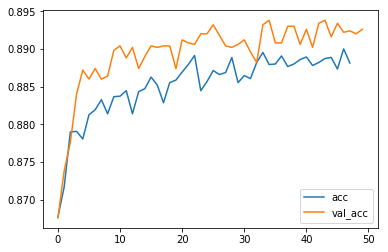

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(h.history['acc'][2:], label='acc')
plt.plot(h.history['val_acc'], label='val_acc')
plt.legend()

In [121]:
y_test = model.predict([X_meta_test, X_test])

In [123]:
y_test = np.array([0 if r0 > r1 else 1 for r0, r1 in y_test])

In [124]:
np.savetxt('nn_output.txt', np.dstack((np.arange(1, y_test.shape[0] + 1), y_test.T))[0], "%d,%d", delimiter=',', header="Id,Prediction", comments="")

In [14]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
def AdaBoost(n_estimators=250, learning_rate=1):
    adaboost_classes_train = np.empty(y_train.shape)
    adaboost_classes_test = np.empty(X_meta_test.shape[0])

    cursplit = 0;
    
    for train_index, test_index in kf.split(X_meta_train, y_train):
        cursplit += 1
        print('Adaboost, split=%d' % (cursplit))
        clf = BaggingClassifier(base_estimator=
                                AdaBoostClassifier(base_estimator=
                                                   ExtraTreesClassifier(n_estimators=200, 
                                                                        max_features='sqrt', 
                                                                        criterion='gini'),
                                                   n_estimators=n_estimators
                                                  ), 
                                n_estimators=n_estimators)

        clf.fit(X_meta_train[train_index], y_train[train_index])
        adaboost_classes_train[test_index] = clf.predict_proba(X_meta_train[test_index])[:, 1]
        print('Eval accuracy: %f' % (1 - np.sum(np.abs(np.rint(adaboost_classes_train[test_index]) - y_train[test_index])) / y_train.shape[0]))
    
    print('Adaboost, test')
    clf = BaggingClassifier(base_estimator=
                                AdaBoostClassifier(base_estimator=
                                                   ExtraTreesClassifier(n_estimators=200, 
                                                                        max_features='sqrt', 
                                                                        criterion='gini'),
                                                   n_estimators=n_estimators
                                                  ), 
                                n_estimators=n_estimators)
    clf.fit(X_meta_train, y_train)
    adaboost_classes_test = clf.predict_proba(X_meta_test)[:, 1]
    
    return adaboost_classes_train, adaboost_classes_test

In [15]:
train_results, test_results = AdaBoost(250)
np.savetxt('../inferences/2/ada2_train.txt' ,train_results, fmt='%.6g')
np.savetxt('../inferences/2/ada2_test.txt' ,test_results, fmt='%.6g')
print('Accuracy: %f' % (1 - np.sum(np.abs((train_results) - y_train)) / y_train.shape[0]))

Adaboost, split=1


MemoryError: 

In [ ]:
print('Accuracy: %f' % (1 - np.sum(np.abs(np.rint(train_results) - y_train)) / y_train.shape[0]))

In [16]:
!ls

Untitled.ipynb
file_format_convert.ipynb
generate_first_layer.ipynb
generate_second_layer.ipynb
nn_output.txt
test_output.txt
